# **Mountain Car Continuous Model Based on Descending Random Propelling with the Architecture of Deep Deterministic Policy Gradient (DDPG) Reinforcement Learning Algorithm**
I know it is a really long name...

# Abstract
This model is based on ***DDPG*** Reinformcement Learning Algorithm. Our goal is let the car go upon the hill to reach the flag. However, the momentum of the car cannot support the car to go directly to the top at a time. Thus, the car need to use the hill on the left to accelerate itself to rush upon the right hill to reach the flag.

The main problem is that the penalty of movement may cause the car to stay still and not taking any action. This is because the positive reward is too difficult to reach and the penalty of exploring is too high. Generally, if the car never reaches the flag, it will eventually choose to stay still.

My solution to solve this problem is adding a descending random propelling (which is considered as ***noise***) to the action that the neural network is generating. By doing this, we can literally "propel" the car to go, so that it cannot stay still.

**Mountain Car MDP**


The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. We will experiment with the continouse version in this one.


![Mountain Car](https://gymnasium.farama.org/_images/mountain_car_continuous.gif)

The observation is a ndarray with shape (2,) where the elements correspond to the position of the car along the x-axis and the velocity of the car.

The action is a ndarray with shape (1,), representing the directional force applied on the car. The action is clipped in the range [-1,1] and multiplied by a power of 0.0015.

A negative reward of $-0.1 * action^2$ is received at each timestep to penalise for taking actions of large magnitude. If the mountain car reaches the goal then a positive reward of +100 is added to the negative reward for that timestep.

You can read more the MountainCar Continous environment [here](https://gymnasium.farama.org/environments/classic_control/mountain_car_continuous/)

## Continous Action Spaces

It's conceptually the same as for discrete action spaces. In discrete action spaces you have a discrete distribution like the categorical distribution and you calculate the log pi probabilities using its mass function. In continuous action spaces you use a continuous distribution like the Gaussian distribution and calculate the log pi “probabilities” using its density function. Everything else is the same.

So instead of having network that outputs the parameters for a categorical distribution, you have a network that outputs parameters for (usually) a Gaussian distribution (i.e. the mean and standard deviation)

But, usually we just output the mean using a neural network, and have a separate set of learnable parameters for std (in log space) for each action. For example, if we 3 continous actions then we will have a neural network which will output the means for these actions and then separate 3 parameters which will represent the log std of these actions. We still learn these log std but they are not dependent on state. We just have a log std for each action.

Other approaches for std include:
- Having a std as output of neural network just as the mean.
- Initializing some std for all actions at start and then steadily decrease if using a std_decay hyperparameter as the training progresses.


You can use any appraoch you like.



## Reinforce

REINFORCE is an elegant algorithm for maximizing the expected return. We sample a trajectory $\tau$ . If we get a high reward, we try to make it more likely. If we get a low reward, we try to make it less likely.

We just need a policy that maximizes the expected return and we can do this by Gradient Ascent on Policy parameters.

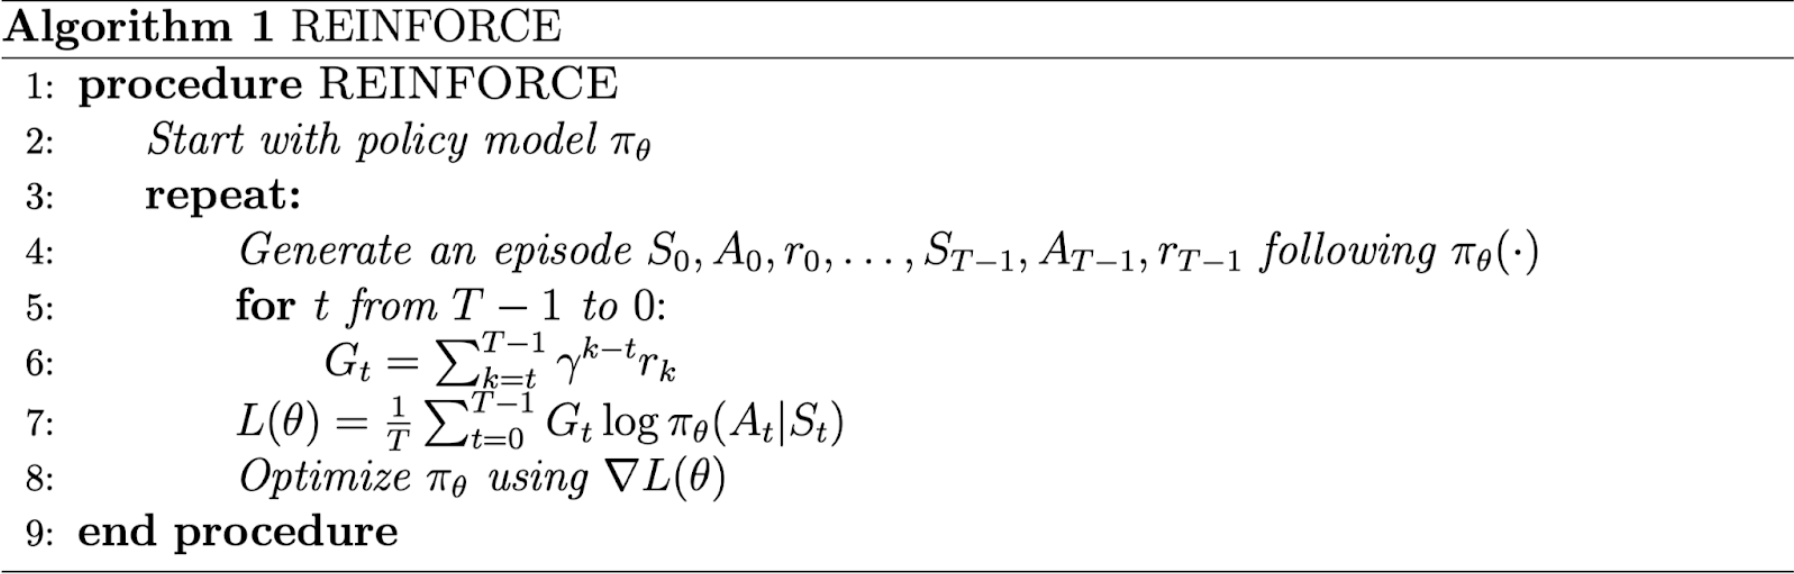




### Hints
- Try to use at least a 3 to 4 layer network with tanh activation at last layer.
- Use high value of gamma and max_steps
- Try to understand the reward function and think how the agent can get stuck in a non-optimal reward trajectory.

# Deep Deterministic Policy Gradient (DDPG) Algorithm

The stochastic policy gradient calculating formula based on Q value is:
$$
\nabla_\theta J(\pi_\theta) = E_{s\sim\rho ^ \pi,a\sim \pi_\theta}[\nabla_\theta \log \pi_\theta (s,a)Q_\pi(s,a)]
$$

The deterministic policy gradient calculating formula based on Q value is:
$$
\nabla_\theta J(\pi_\theta) = E_{s\sim\rho ^ \pi}[\nabla_\theta \pi_\theta (s) \nabla_a Q_\pi(s,a)|_{a=\pi_\theta (s)}]
$$

## DDPG Brief Principle

Very generally speaking, DDPG Algorithm is a combination of DQN Algorithm and Actor-and-Critic Algorithm. Where both actor network and critic network are separated into policy network and target network. So, there will be 4 neural network in total.

## More Specifically...

DDPG has 4 networks: Actor Current network, Actor target network, Critic Current network, Critic target network. The structure of the two Actor networks is the same, and the structure of the two Critic networks is the same.

The current Q network of DQN is responsible for using **ϵ− greedy** method to select the action $A$ for the current state $S$, perform the action $A$, obtain the new state $S'$ and reward $R$, put the sample into the experience ***replay pool***, and use greedy method to select the action $A$ for the next state $S'$ sampled in the experience replay pool, so that the target Q network can calculate the target Q value. After the target Q network has calculated the target Q value, The current Q network updates network parameters and periodically copies the latest network parameters to the target Q network.

By analogy with DQN, the current network of Critic in DDPG, the target network of Critic and the current Q network of DQN, the functional positioning of the target Q network is basically similar. However, there is no need to be greedy when selecting an action, and it is done with the Actor current network. The greedy method is used to select the action $A$ for the next state $S'$ sampled in the experience replay pool. This part of the work is used to estimate the target Q value, so it can be completed in the Actor target network.

- **Actor Current network**: Responsible for the iterative update of policy network parameters $\theta$, responsible for selecting the current action $A$ according to the current state $S$, for interacting with the environment to generate $S'$ and $R$.

- **Actor Target Network**: Responsible for selecting the optimal next action $A$ based on the next state $S'$ sampled in the experiential replay pool. Network parameters are periodically replicated.

- **Critic Current network**: Responsible for the iterative update of the value network parameter $w$, responsible for calculating the current Q value $Q(S,A,w)$.

- **Critic Target network**: Responsible for calculating the target Q value. Where $Q' = R + \gamma Q'(S', A', w')$

Additionally, the way DDPG copies the current network parameters to the target network has changed.

In DQN, we copy the parameters of the current Q network directly to the target Q network. (A hard copy)

But now we need a soft copy to update the parameters.:
$$
w' \leftarrow \tau w + (1-\tau)w'
$$

$$
\theta' \leftarrow \tau \theta + (1-\tau)\theta'
$$

At the same time, in order to add some randomness to the learning process and increase the coverage of learning, DDPG will add some noise $N$ to the selected actions, that is, the expression of the final action $A$ interacting with the environment is:

$$
A = \pi_\theta(s) + N
$$

And this is considered to be the *propelling*.

For the Critic Current network, the loss function is basically the MSE loss.

For the Actor Current network, the loss gradient is:
$$
\nabla_J (\theta) = \frac{1}{m}\sum_{j=1} ^ m [\nabla_a Q(s_i,a_i,w)|_{s=s_i,a=\pi_\theta(s)}\nabla_\theta \pi_\theta (s)|_{s=s_i}]
$$


# Import Library

In [ ]:
from gym import make
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy
from collections import deque
from matplotlib import pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## MountainCarContinuous-v0

In [ ]:
env = make("MountainCarContinuous-v0")
np.random.seed(9)
env.seed(9)

action_size = env.action_space.shape[0]
print(f'size of eche action = {action_size}')
state_size = env.observation_space.shape[0]
print(f'size of state = {state_size}')

size of eche action = 1
size of state = 2


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


## Defining Actor Neural Network

In [ ]:
class Actor(nn.Module):
    def __init__(self, state_size, action_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(state_size, 32)
        self.linear2 = nn.Linear(32, 32)
        self.linear3 = nn.Linear(32, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.linear1.weight.data.normal_(0, 1e-1)
        self.linear2.weight.data.normal_(0, 1e-1)
        self.linear3.weight.data.normal_(0, 1e-2)

    def forward(self, state):
        x = state
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return torch.tanh(x)

## Defining Critic Neural Network

In [ ]:
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(state_size + action_size, 64)
        self.linear2 = nn.Linear(64, 64)
        self.linear3 = nn.Linear(64, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.linear1.weight.data.normal_(0, 1e-1)
        self.linear2.weight.data.normal_(0, 1e-1)
        self.linear3.weight.data.normal_(0, 1e-2)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.linear3(x)
        return x

## Memory Replay

In [ ]:
# Prof. Khan's method
class Memory:
    def __init__(self, buffer_size, batch_size):
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.memory = []
        self.position = 0

    def push(self, element):
        if len(self.memory) < self.buffer_size:
            self.memory.append(None)
        self.memory[self.position] = element
        self.position = (self.position + 1) % self.buffer_size

    def sample(self):
        return list(zip(*random.sample(self.memory, self.batch_size)))

    def __len__(self):
        return len(self.memory)

## Defining the DDPG Agent
The target networks is updated every episode. The result is still acceptable.

In [ ]:
class Agent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, gamma, tau):
         # Actor Network and Target Network
        self.actor = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-3)

        # Critic Network and Target Network
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # copy weights
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)

        self.memory = Memory(buffer_size, batch_size)
        self.gamma = gamma
        self.tau = tau
        self.std = 1 # A parameter that will descend to calculate the noise

    def hard_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, target, network):
        for target_param, param in zip(target.parameters(), network.parameters()):
            target_param.data.copy_(self.tau*param.data + (1-self.tau)*target_param.data)

    def learn(self, batch):

        state, action, reward, next_state, done = batch

        state = torch.tensor(state).to(device).float()
        next_state = torch.tensor(next_state).to(device).float()
        reward = torch.tensor(reward).to(device).float()
        action = torch.tensor(action).to(device)
        done = torch.tensor(done).to(device).int()

        # update critic
        next_action = self.actor_target(next_state)

        Q_target = self.critic_target(next_state, next_action).detach()
        Q_target = reward.unsqueeze(1) + (self.gamma*Q_target*((1-done).unsqueeze(1)))


        critic_loss = F.mse_loss(self.critic(state, action), Q_target)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # update actor

        action_prediction = self.actor(state)
        actor_loss = -self.critic(state, action_prediction).mean()


        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # update actor_target and critic_target

        self.soft_update(self.critic_target, self.critic)
        self.soft_update(self.actor_target, self.actor)

    def act(self, state, noise = True):
        state =  torch.tensor(state).to(device).float()
        action = self.actor(state).cpu().data.numpy()

        if noise:
            noise = np.random.normal(0, self.std)
            action = action + noise

        if action[0] > 1:
            action[0] = 1
        if action[0] < -1:
            action[0] = -1
        return action

    def step(self, state, action, reward, next_state, done):
        self.memory.push((state, action, reward, next_state, done))
        if len(self.memory) >= self.memory.batch_size:
            self.learn(self.memory.sample())

    def save(self):
        torch.save(self.actor, "actor.pkl")
        torch.save(self.critic, "critic.pkl")

    def test(self):
        new_env = make("MountainCarContinuous-v0")
        new_env.seed(9)
        reward = []
        for i in range(50):
            state = new_env.reset()
            local_reward = 0
            done = False
            while not done:
                action = self.act(state, noise = False)
                state, r, done, _ = new_env.step(action)
                local_reward += r
            reward.append(local_reward)
        return reward



# Training

## Hyperparameters

In [ ]:
BUFFER_SIZE = 100000
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
EPISODES = 100
MEAN_INIT = -20000

In [ ]:
reward_list = []
def ddpg(episodes):
    agent = Agent(state_size = state_size, action_size = action_size,
              buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE,
              gamma = GAMMA, tau = TAU)

    mean_reward = MEAN_INIT
    for i in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            total_reward += reward
            state = next_state

        reward_list.append(total_reward)
        agent.std = max(agent.std - 0.01, 0.1)
        if total_reward > 50:
            r = agent.test()
            local_mean = np.mean(r)
            print(f"episode: {i+1}, current reward: {total_reward}, max reward: {np.max(r)}, mean reward: {local_mean}")
            if local_mean > mean_reward:
                mean_reward = local_mean
                agent.save()
                print("Saved")
        else:
            print(f"episode: {i+1}, current reward: {total_reward}")

ddpg(EPISODES)

<ipython-input-6-c9ee68a5f347>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  state = torch.tensor(state).to(device).float()


episode: 1, current reward: -53.43418926336603
episode: 2, current reward: -51.20649393541378
episode: 3, current reward: -47.96385159716762
episode: 4, current reward: -50.517581957962534
episode: 5, current reward: -50.19447661544418
episode: 6, current reward: -48.13846743855923
episode: 7, current reward: -49.35616604973566
episode: 8, current reward: -47.8565854021868
episode: 9, current reward: -45.91337604087999
episode: 10, current reward: 70.41092470814189, max reward: -0.3852693049239107, mean reward: -0.38538872217453624
Saved
episode: 11, current reward: -45.36698919110355
episode: 12, current reward: -46.54947094683689
episode: 13, current reward: -46.209403872094825
episode: 14, current reward: -46.33685438249856
episode: 15, current reward: -45.47803375735447
episode: 16, current reward: -44.15763514001603
episode: 17, current reward: -45.25377021560724
episode: 18, current reward: -44.439778090002484
episode: 19, current reward: -42.72275694280806
episode: 20, current r

# Visualization of the rewards
Although there are only 100 episodes, the agent still converged and stablised to a reward that is very close to 100 (usually 90+). The curve of rewards shows that the agent is continuously learning and making progress.

Text(0, 0.5, 'Reward')

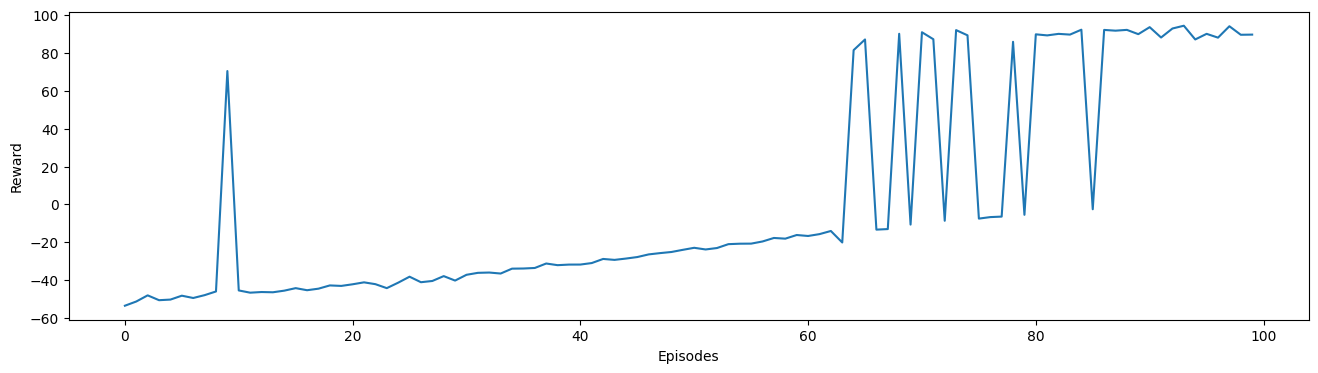

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(reward_list)
plt.xlabel("Episodes")
plt.ylabel("Reward")

We do not need the critic any more...

In [ ]:
actor = torch.load("actor.pkl")
actor.to(device)

# critic = torch.load("critic.pkl")
# critic.to(device)

Actor(
  (linear1): Linear(in_features=2, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
def game_act(state):
        state =  torch.tensor(state).to(device).float()
        action = actor(state).cpu().data.numpy()
        return action

## Test the Agent & Visualization

In [ ]:
# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
import base64, io, os

os.environ['SDL_VIDEODRIVER']='dummy'

In [ ]:
reward = []
os.makedirs("video", exist_ok=True)
for i in range(1):
    state = env.reset()
    vid = video_recorder.VideoRecorder(env, path="video/{}.mp4".format("MountainCarContinuous-v0"))
    local_reward = 0
    done = False
    while not done:
        vid.capture_frame()
        action = game_act(state)
        state, r, done, _ = env.step(action)
        local_reward += r
    reward.append(local_reward)
vid.close()
env.close()
print("Final reward: ", reward)

mp4list = glob.glob('video/*.mp4')
if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format("MountainCarContinuous-v0")
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
else:
        print("Could not find video")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment MountainCarContinuous-v0 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode 

Final reward:  [94.08603219596174]
